In [32]:
import gc
import glob
import os
import json
import matplotlib.pyplot as plt
import pprint

import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from tqdm import tqdm
from PIL import Image

%matplotlib inline

pd.options.display.max_rows = 128
pd.options.display.max_columns = 128

In [5]:
plt.rcParams['figure.figsize'] = (12, 9)

### load core DFs (train and test):

In [15]:
path = '/home/gsm/Documents/extras/kaggle/petfinder/'

In [16]:
ls /home/gsm/Documents/extras/

cats_dogs/  kaggle/


In [17]:
train = pd.read_csv(path+'train/train.csv')
test = pd.read_csv(path+'test/test.csv')
#sample_submission = pd.read_csv('../input/test/sample_submission.csv')

### load mapping dictionaries:

In [18]:
labels_breed = pd.read_csv(path+'/breed_labels.csv')
labels_state = pd.read_csv(path+'/color_labels.csv')
labels_color = pd.read_csv(path+'/state_labels.csv')

### additional data:

We have also additional information about pets available in form of:

- images
- metadata
- sentiment

Integration of those will enable us to possibly improve the score.
Information derived from example from images should be very important, as picture of a pet influences the way we look at an animal in a significant way.

In [23]:
ls /home/gsm/Documents/extras/kaggle/petfinder/train

train.csv  train_images/  train_meta/  train_sent/


In [27]:
train_image_files = sorted(glob.glob(path+'train/train_images/*.jpg'))
train_metadata_files = sorted(glob.glob(path+'train/train_meta/*.json'))
train_sentiment_files = sorted(glob.glob(path+'train/train_sent/*.json'))

print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))


test_image_files = sorted(glob.glob(path+'test/test_images/*.jpg'))
test_metadata_files = sorted(glob.glob(path+'test/test_meta/*.json'))
test_sentiment_files = sorted(glob.glob(path+'test/test_sent/*.json'))

print('num of test images files: {}'.format(len(test_image_files)))
print('num of test metadata files: {}'.format(len(test_metadata_files)))
print('num of test sentiment files: {}'.format(len(test_sentiment_files)))

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 15040
num of test metadata files: 15040
num of test sentiment files: 3815


### train analysis:

In [28]:
plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')


# Images:
train_df_ids = train[['PetID']]
print(train_df_ids.shape)

train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
print(len(train_imgs_pets.unique()))

pets_with_images = len(np.intersect1d(train_imgs_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with images: {:.3f}'.format(pets_with_images / train_df_ids.shape[0]))

# Metadata:
train_df_ids = train[['PetID']]
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_metadata = train_df_metadata.assign(PetID=train_metadata_pets)
print(len(train_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(train_metadata_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas / train_df_ids.shape[0]))

# Sentiment:
train_df_ids = train[['PetID']]
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
train_df_sentiment = train_df_sentiment.assign(PetID=train_sentiment_pets)
print(len(train_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(train_sentiment_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments / train_df_ids.shape[0]))

(14993, 1)
14652
fraction of pets with images: 0.977
14652
fraction of pets with metadata: 0.977
14442
fraction of pets with sentiment: 0.963


In [29]:
# Images:
test_df_ids = test[['PetID']]
print(test_df_ids.shape)

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)
print(len(test_imgs_pets.unique()))

pets_with_images = len(np.intersect1d(test_imgs_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with images: {:.3f}'.format(pets_with_images / test_df_ids.shape[0]))


# Metadata:
test_df_ids = test[['PetID']]
test_df_metadata = pd.DataFrame(test_metadata_files)
test_df_metadata.columns = ['metadata_filename']
test_metadata_pets = test_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_metadata = test_df_metadata.assign(PetID=test_metadata_pets)
print(len(test_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(test_metadata_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas / test_df_ids.shape[0]))



# Sentiment:
test_df_ids = test[['PetID']]
test_df_sentiment = pd.DataFrame(test_sentiment_files)
test_df_sentiment.columns = ['sentiment_filename']
test_sentiment_pets = test_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
test_df_sentiment = test_df_sentiment.assign(PetID=test_sentiment_pets)
print(len(test_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(test_sentiment_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments / test_df_ids.shape[0]))


# are distributions the same?
print('images and metadata distributions the same? {}'.format(
    np.all(test_metadata_pets == test_imgs_pets)))

(3948, 1)
3821
fraction of pets with images: 0.968
3821
fraction of pets with metadata: 0.968
3815
fraction of pets with sentiment: 0.966
images and metadata distributions the same? True


### data parsing & feature extraction:

After taking a look at the data, we know its structure and can use it to extract additional features and concatenate them with basic train/test DFs.

In [43]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        
        self.debug = debug
        self.sentence_sep = ' '
        
        # Does not have to be extracted because main DF already contains description
        self.extract_sentiment_text = False
        
        
    def open_metadata_file(self, filename):
        """
        Load metadata file.
        """
        with open(filename, 'r') as f:
            metadata_file = json.load(f)
        return metadata_file
            
    def open_sentiment_file(self, filename):
        """
        Load sentiment file.
        """
        with open(filename, 'r') as f:
            sentiment_file = json.load(f)
        return sentiment_file
            
    def open_image_file(self, filename):
        """
        Load image file.
        """
        image = np.asarray(Image.open(filename))
        return image
        
    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)

        if self.extract_sentiment_text:
            file_sentences_text = [x['text']['content'] for x in file['sentences']]
            file_sentences_text = self.sentence_sep.join(file_sentences_text)
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns').sum()
        file_sentences_sentiment = file_sentences_sentiment.add_prefix('document_').to_dict()
        
        file_sentiment.update(file_sentences_sentiment)
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        if self.extract_sentiment_text:
            df_sentiment['text'] = file_sentences_text
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment
    
    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """
        
        file_keys = list(file.keys())
        
        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations'][:int(len(file['labelAnnotations']) * 0.3)]
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']
        
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()
        
        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }
        
        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    

# Helper function for parallel data processing:
def extract_additional_features(pet_id, mode='train'):
    
    sentiment_filename = path+f'{mode}/{mode}_sent/{pet_id}.json'
    try:
        sentiment_file = pet_parser.open_sentiment_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob(path+f'{mode}/{mode}_meta/{pet_id}*.json'))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_metadata_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True, sort=False)
    dfs = [df_sentiment, dfs_metadata]
    
    return dfs


pet_parser = PetFinderParser()

In [44]:
# Unique IDs from train and test:
debug = False
train_pet_ids = train.PetID.unique()
test_pet_ids = test.PetID.unique()

if debug:
    train_pet_ids = train_pet_ids[:1000]
    test_pet_ids = test_pet_ids[:500]


# Train set:
# Parallel processing of data:
dfs_train = Parallel(n_jobs=6, verbose=1)(
    delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

# Extract processed data and format them as DFs:
train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]

train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True, sort=False)
train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True, sort=False)

print(train_dfs_sentiment.shape, train_dfs_metadata.shape)


# Test set:
# Parallel processing of data:
dfs_test = Parallel(n_jobs=6, verbose=1)(
    delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

# Extract processed data and format them as DFs:
test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]

test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True, sort=False)
test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True, sort=False)

print(test_dfs_sentiment.shape, test_dfs_metadata.shape)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   14.3s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   33.3s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 2464 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3564 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4864 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6364 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8064 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 9964 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12064 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 14364 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 14982 out of 14993 | elapsed:  9.9min remaining:    0.4s
[Parallel(n_jobs=6)]: Done 14993 out of 14993 | elapsed:  9.9min finished


(14442, 6) (58311, 7)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 716 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done 1716 tasks      | elapsed:   25.2s
[Parallel(n_jobs=6)]: Done 3116 tasks      | elapsed:   45.5s
[Parallel(n_jobs=6)]: Done 3948 out of 3948 | elapsed:   57.7s finished


(3815, 6) (15040, 7)


In [52]:
# import pickle
# with open('dump_data/test_dfs_','wb') as f:
#     pickle.dump(test_dfs_,f)

### group extracted features by PetID:

In [53]:
# Extend aggregates and improve column naming
aggregates = ['mean', 'sum']


# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(aggregates)
train_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(aggregates)
test_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

### merge processed DFs with base train/test DF:

In [54]:
# Train merges:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')


print(train_proc.shape, test_proc.shape)
assert train_proc.shape[0] == train.shape[0]
assert test_proc.shape[0] == test.shape[0]

(14993, 44) (3948, 43)


### add breed mapping:

In [55]:
train_breed_main = train_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix('main_breed_')

train_breed_second = train_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix('second_breed_')


train_proc = pd.concat(
    [train_proc, train_breed_main, train_breed_second], axis=1)


test_breed_main = test_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

test_breed_main = test_breed_main.iloc[:, 2:]
test_breed_main = test_breed_main.add_prefix('main_breed_')

test_breed_second = test_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

test_breed_second = test_breed_second.iloc[:, 2:]
test_breed_second = test_breed_second.add_prefix('second_breed_')


test_proc = pd.concat(
    [test_proc, test_breed_main, test_breed_second], axis=1)

print(train_proc.shape, test_proc.shape)

(14993, 48) (3948, 47)


### concatenate train & test:

Inspect NaN structure of the processed data:
`AdoptionSpeed` is the target column.

In [59]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)
print('NaN structure:\n{}'.format(np.sum(pd.isnull(X))))

NaN structure:
Type                                               0
Name                                            1560
Age                                                0
Breed1                                             0
Breed2                                             0
Gender                                             0
Color1                                             0
Color2                                             0
Color3                                             0
MaturitySize                                       0
FurLength                                          0
Vaccinated                                         0
Dewormed                                           0
Sterilized                                         0
Health                                             0
Quantity                                           0
Fee                                                0
State                                              0
RescuerID                      

### extract different column types:

- integer columns are usually categorical features, which do not need encoding
- float columns are numerical features
- object columns are categorical features, which should be encoded

In [60]:
column_types = X.dtypes

int_cols = column_types[column_types == 'int']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

print('\tinteger columns:\n{}'.format(int_cols))
print('\n\tfloat columns:\n{}'.format(float_cols))
print('\n\tto encode categorical columns:\n{}'.format(cat_cols))

	integer columns:
Type            int64
Age             int64
Breed1          int64
Breed2          int64
Gender          int64
Color1          int64
Color2          int64
Color3          int64
MaturitySize    int64
FurLength       int64
Vaccinated      int64
Dewormed        int64
Sterilized      int64
Health          int64
Quantity        int64
Fee             int64
State           int64
VideoAmt        int64
dtype: object

	float columns:
PhotoAmt                                       float64
AdoptionSpeed                                  float64
sentiment_sentiment_magnitude_MEAN             float64
sentiment_sentiment_magnitude_SUM              float64
sentiment_sentiment_score_MEAN                 float64
sentiment_sentiment_score_SUM                  float64
sentiment_sentiment_document_magnitude_MEAN    float64
sentiment_sentiment_document_magnitude_SUM     float64
sentiment_sentiment_document_score_MEAN        float64
sentiment_sentiment_document_score_SUM         float64
metad

### feature engineering:

In [61]:
# Copy original X DF for easier experimentation,
# all feature engineering will be performed on this one:
X_temp = X.copy()


# Select subsets of columns:
text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']
categorical_columns = ['main_breed_BreedName', 'second_breed_BreedName']

# Names are all unique, so they can be dropped by default
# Same goes for PetID, it shouldn't be used as a feature
to_drop_columns = ['PetID', 'Name', 'RescuerID']
# RescuerID will also be dropped, as a feature based on this column will be extracted independently

In [62]:
# Count RescuerID occurrences:
rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']

# Merge as another feature onto main DF:
X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')

In [63]:
# Factorize categorical columns:
for i in categorical_columns:
    X_temp.loc[:, i] = pd.factorize(X_temp.loc[:, i])[0]

In [64]:
# Subset text features:
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('<MISSING>')

/home/gsm/miniconda3/envs/dsml/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation, NMF

n_components = 5
text_features = []


# Generate text features:
for i in X_text.columns:
    
    # Initialize decomposition methods:
    print('generating features from: {}'.format(i))
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1337)
    nmf_ = NMF(
        n_components=n_components, random_state=1337)
    
    tfidf_col = TfidfVectorizer().fit_transform(X_text.loc[:, i].values)
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('SVD_{}_'.format(i))
    
    nmf_col = nmf_.fit_transform(tfidf_col)
    nmf_col = pd.DataFrame(nmf_col)
    nmf_col = nmf_col.add_prefix('NMF_{}_'.format(i))
    
    text_features.append(svd_col)
    text_features.append(nmf_col)

    
# Combine all extracted features:
text_features = pd.concat(text_features, axis=1)

# Concatenate with main DF:
X_temp = pd.concat([X_temp, text_features], axis=1)

# Remove raw text columns:
for i in X_text.columns:
    X_temp = X_temp.drop(i, axis=1)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


In [66]:
# Remove unnecessary columns:
X_temp = X_temp.drop(to_drop_columns, axis=1)

# Check final df shape:
print('X shape: {}'.format(X_temp.shape))

X shape: (18941, 73)


### train/test split:

In [67]:
# Split into train and test again:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

# Remove missing target column from test:
X_test = X_test.drop(['AdoptionSpeed'], axis=1)


print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]


# Check if columns between the two DFs are the same:
train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)

X_train shape: (14993, 73)
X_test shape: (3948, 72)


In [84]:
X_train

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,sentiment_sentiment_magnitude_MEAN,sentiment_sentiment_magnitude_SUM,sentiment_sentiment_score_MEAN,sentiment_sentiment_score_SUM,sentiment_sentiment_document_magnitude_MEAN,sentiment_sentiment_document_magnitude_SUM,sentiment_sentiment_document_score_MEAN,sentiment_sentiment_document_score_SUM,metadata_metadata_annots_score_MEAN,metadata_metadata_annots_score_SUM,metadata_metadata_color_score_MEAN,metadata_metadata_color_score_SUM,metadata_metadata_color_pixelfrac_MEAN,metadata_metadata_color_pixelfrac_SUM,metadata_metadata_crop_conf_MEAN,metadata_metadata_crop_conf_SUM,metadata_metadata_crop_importance_MEAN,metadata_metadata_crop_importance_SUM,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName,RescuerID_COUNT,SVD_Description_0,SVD_Description_1,SVD_Description_2,SVD_Description_3,SVD_Description_4,NMF_Description_0,NMF_Description_1,NMF_Description_2,NMF_Description_3,NMF_Description_4,SVD_metadata_annots_top_desc_0,SVD_metadata_annots_top_desc_1,SVD_metadata_annots_top_desc_2,SVD_metadata_annots_top_desc_3,SVD_metadata_annots_top_desc_4,NMF_metadata_annots_top_desc_0,NMF_metadata_annots_top_desc_1,NMF_metadata_annots_top_desc_2,NMF_metadata_annots_top_desc_3,NMF_metadata_annots_top_desc_4,SVD_sentiment_entities_0,SVD_sentiment_entities_1,SVD_sentiment_entities_2,SVD_sentiment_entities_3,SVD_sentiment_entities_4,NMF_sentiment_entities_0,NMF_sentiment_entities_1,NMF_sentiment_entities_2,NMF_sentiment_entities_3,NMF_sentiment_entities_4
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2.0,2.4,2.4,0.3,0.3,2.2,2.2,1.8,1.8,0.973658,0.973658,0.074838,0.074838,0.066331,0.066331,0.800000,0.800000,1.000000,1.00,2.0,0,NaN,-1,8,2.965651e-01,-1.790638e-02,-5.916609e-02,3.866681e-02,-6.220802e-02,0.032970,0.006753,0.011146,0.035306,0.000000,9.796106e-02,3.703953e-01,2.121993e-07,-4.415909e-02,5.190107e-02,0.000000,0.043480,0.000,0.000000,0.003832,1.106065e-06,8.059259e-02,-5.902075e-02,5.817742e-02,3.126198e-02,0.000000e+00,0.000761,0.000000,0.029575,0.005587
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0.0,0.7,0.7,-0.2,-0.2,0.7,0.7,-0.5,-0.5,0.938851,1.877702,0.091708,0.183415,0.063681,0.127362,0.800000,1.600000,1.000000,2.00,2.0,1,NaN,-1,1,1.649469e-01,-4.322119e-02,-2.667170e-02,-1.561239e-02,-2.623700e-02,0.020478,0.000000,0.009702,0.010843,0.004728,2.258169e-01,9.033502e-01,1.383880e-07,1.299874e-01,-1.170992e-01,0.000000,0.106186,0.000,0.000000,0.000000,3.120074e-06,9.100753e-02,-6.648504e-02,3.505831e-02,6.075328e-02,0.000000e+00,0.000822,0.000000,0.025197,0.018219
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,3.0,3.7,3.7,0.2,0.2,3.4,3.4,1.4,1.4,0.951833,6.662831,0.094292,0.660042,0.073497,0.514481,0.800000,5.600000,1.000000,7.00,1.0,2,NaN,-1,459,3.470993e-01,1.739526e-02,-7.196653e-02,-1.626358e-01,2.971833e-02,0.050133,0.003783,0.015452,0.000000,0.047331,9.502340e-01,-2.127443e-01,8.729151e-08,-2.047282e-01,5.950640e-02,0.121293,0.000000,0.000,0.011116,0.000000,5.064130e-06,1.586880e-01,-1.230154e-01,-5.753454e-02,7.184696e-02,0.000000e+00,0.021444,0.000603,0.013310,0.039958
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,2.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.948411,7.587288,0.082549,0.660390,0.068542,0.548335,0.800000,6.400000,1.000000,8.00,1.0,2,NaN,-1,50,1.951318e-01,8.556186e-02,4.794402e-02,-2.260726e-02,9.179959e-02,0.000079,0.021380,0.025143,0.007380,0.034710,9.660028e-01,-2.448066e-01,4.265991e-08,-4.887597e-02,-4.501851e-03,0.085719,0.000000,0.000,0.053011,0.000000,2.492512e-06,9.806366e-02,-1.947221e-02,-8.807552e-02,1.768871e-01,0.000000e+00,0.000000,0.000665,0.000000,0.067622
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,2.0,3.7,3.7,0.6,0.6,3.5,3.5,3.5,3.5,0.905170,2.715509,0.079771,0.239312,0.042689,0.128066,0.800000,2.400000,0.993333,2.98,1.0,2,NaN,-1,134,3.807255e-01,4.161815e-02,-1.840909e-01,2.079916e-01,9.096357e

### train and test NaN structure:

In [68]:
np.sum(pd.isnull(X_train))

Type                                               0
Age                                                0
Breed1                                             0
Breed2                                             0
Gender                                             0
Color1                                             0
Color2                                             0
Color3                                             0
MaturitySize                                       0
FurLength                                          0
Vaccinated                                         0
Dewormed                                           0
Sterilized                                         0
Health                                             0
Quantity                                           0
Fee                                                0
State                                              0
VideoAmt                                           0
PhotoAmt                                      

In [24]:
np.sum(pd.isnull(X_test))

Type                                              0
Age                                               0
Breed1                                            0
Breed2                                            0
Gender                                            0
Color1                                            0
Color2                                            0
Color3                                            0
MaturitySize                                      0
FurLength                                         0
Vaccinated                                        0
Dewormed                                          0
Sterilized                                        0
Health                                            0
Quantity                                          0
Fee                                               0
State                                             0
VideoAmt                                          0
PhotoAmt                                          0
sentiment_se

### model training:

In [69]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [70]:
import lightgbm as lgb

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 1000
n_splits = 5

In [71]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=n_splits, random_state=1337)


oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    
    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)
    
    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)
    
    print('\ny_tr distribution: {}'.format(Counter(y_tr)))
    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    oof_train[valid_index] = val_pred
    oof_test[:, i] = test_pred
    
    i += 1


y_tr distribution: Counter({4.0: 3357, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.05986	valid_1's rmse: 1.09492
[200]	training's rmse: 1.00911	valid_1's rmse: 1.07014
[300]	training's rmse: 0.976339	valid_1's rmse: 1.05936
[400]	training's rmse: 0.952816	valid_1's rmse: 1.05245
[500]	training's rmse: 0.933527	valid_1's rmse: 1.04798
[600]	training's rmse: 0.919828	valid_1's rmse: 1.04573
[700]	training's rmse: 0.903831	valid_1's rmse: 1.04356
[800]	training's rmse: 0.888538	valid_1's rmse: 1.04206
[900]	training's rmse: 0.876047	valid_1's rmse: 1.0406
[1000]	training's rmse: 0.864823	valid_1's rmse: 1.03964
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.864823	valid_1's rmse: 1.03964

y_tr distribution: Counter({4.0: 3357, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
Training until validation scores don't improve for 500 rounds.
[100]	training'

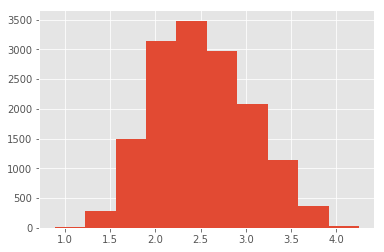

In [73]:
plt.hist(oof_train);

### adapted from: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

In [74]:
# Compute QWK based on OOF train predictions:
optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values))
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({1.0: 4184, 2.0: 4058, 3.0: 3548, 4.0: 3203})
Coefficients =  [0.42288905 2.15925371 2.55341057 2.96253317]
QWK =  0.43957602090676473


In [80]:
# Manually adjusted coefficients:

coefficients_ = coefficients.copy()

coefficients_[0] = 1.645
coefficients_[1] = 2.115
coefficients_[3] = 2.84

train_predictions = optR.predict(oof_train, coefficients_).astype(int)
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_)
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({2: 4486, 4: 4139, 1: 3268, 3: 2612, 0: 488})
test pred distribution: Counter({4.0: 1155, 2.0: 1134, 1.0: 881, 3.0: 663, 0.0: 115})


In [81]:
# Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(X_train['AdoptionSpeed'], normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

True Distribution:
0.0    0.027346
1.0    0.206096
2.0    0.269259
3.0    0.217368
4.0    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.032549
1    0.217968
2    0.299206
3    0.174215
4    0.276062
dtype: float64

Test Predicted Distribution:
0.0    0.029129
1.0    0.223151
2.0    0.287234
3.0    0.167933
4.0    0.292553
dtype: float64


In [82]:
# Generate submission:

submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4db5e7a908>]],
      dtype=object)

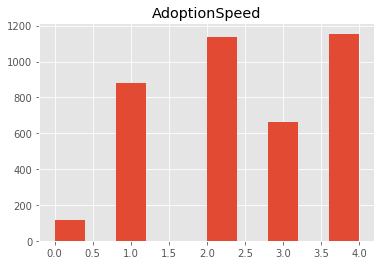

In [83]:
submission.hist()